In [ ]:
!pip install catboost

In [ ]:
!pip install catboost xgboost lightgbm

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:31:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5163
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 26
[LightGBM] [Info] Start training from score -1.656006
[LightGBM] [Info] Start training from score -1.406293
[LightGBM] [Info] Start training from score -0.572612
                    Accuracy Precision  Recall  F1 Score   AUC-ROC  \
Random Forest         0.8615  0.872142  0.8615  0.862007  0.944337   
LightGBM              0.8559  0.868887  0.8559  0.856394  0.941796   
XGBoost               0.8537  0.863763  0.8537  0.854252  0.943683   
CatBoost              0.8508  0.861874  0.8508  0.851345  0.942209   
Extra Trees           0.8461  0.851624  0.8461  0.846684  0.941204   
Decision Tree         0.7838  0.783264  0.7838  0.783333  0.816373   
AdaBoost              0.7595   0.76382  0.7595  0.753086  0

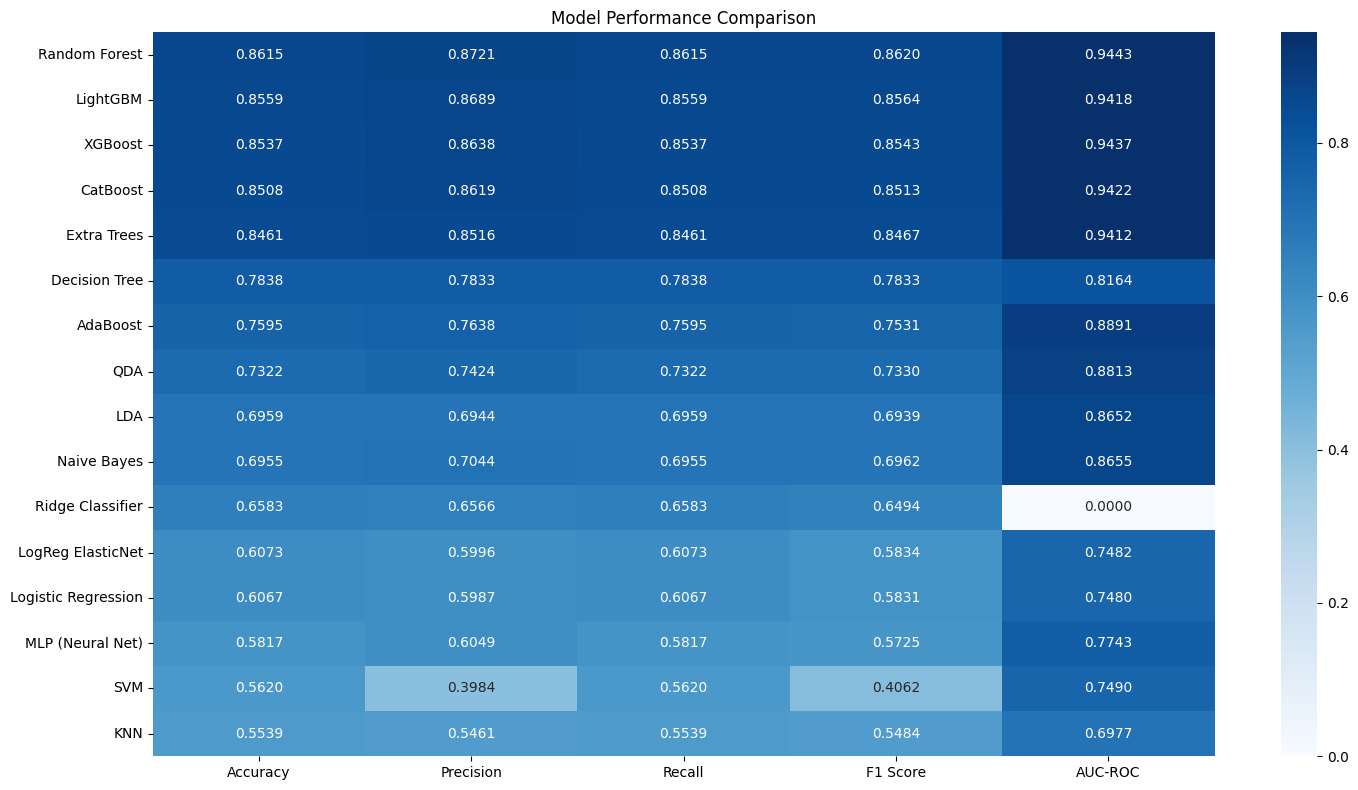

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load dataset
df = pd.read_csv("/Bank Data.csv")
df.replace(["_", "NA"], np.nan, inplace=True)
df.drop_duplicates(inplace=True)

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Impute missing values
num_imputer = SimpleImputer(strategy="mean")
cat_imputer = SimpleImputer(strategy="most_frequent")
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Label encoding
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# Scaling
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Prepare features and labels
X = df.drop("Credit_Mix", axis=1)
y = df["Credit_Mix"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "MLP (Neural Net)": MLPClassifier(max_iter=1000, random_state=42),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "Ridge Classifier": RidgeClassifier(),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LogReg ElasticNet": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
}

# Results dict
results = {}

for name, model in models.items():
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()

    y_prob = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0),
        "AUC-ROC": roc_auc_score(y_test, y_prob, multi_class='ovr') if y_prob is not None else None,
        "Training Time (s)": round(end_train - start_train, 4),
        "Prediction Time (s)": round(end_pred - start_pred, 4),
        "Interpretability": "High" if name in ["Decision Tree", "Logistic Regression", "Ridge Classifier", "LDA"] else
                            "Moderate" if name in ["Random Forest", "SVM", "KNN"] else "Low"
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)
print(results_df)

# Convert metrics to numeric (especially handles None in AUC-ROC)
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC-ROC"]
heatmap_df = results_df[metrics].apply(pd.to_numeric, errors="coerce")

# Fill NaNs with 0 or another placeholder
heatmap_df.fillna(0, inplace=True)

# Visualization
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_df, annot=True, cmap="Blues", fmt=".4f")
plt.title("Model Performance Comparison")
plt.tight_layout()
plt.savefig("model_comparison.png")
plt.show()


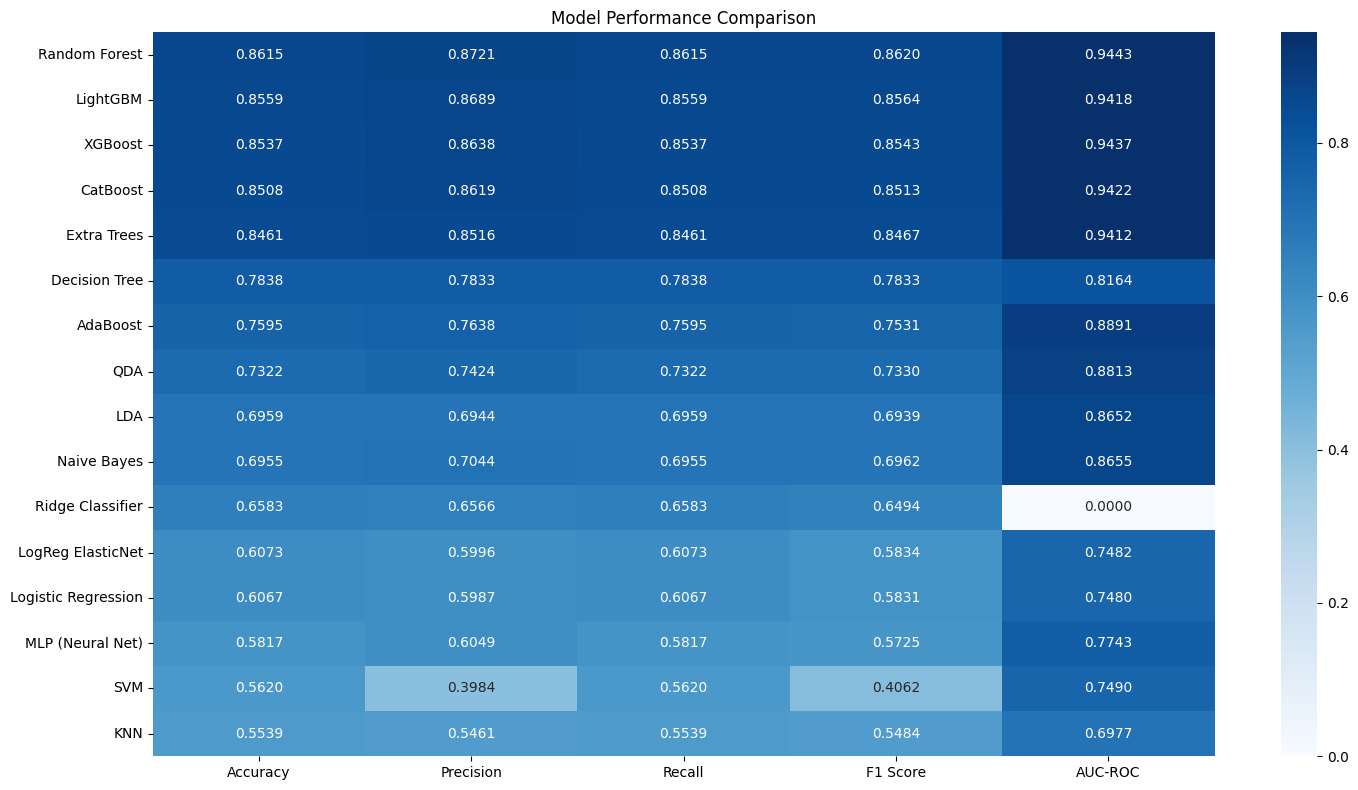

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your existing heatmap_df must be already defined
plt.figure(figsize=(15, 8))
sns.heatmap(heatmap_df, annot=True, cmap="Blues", fmt=".4f")
plt.title("Model Performance Comparison")
plt.tight_layout()

# Save the image
plt.savefig("model_comparison.png")

# Show the image in Colab
plt.show()


In [ ]:
from google.colab import files
files.download("model_comparison.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Hyper Tuing for Ranodm Forest Algo **bold text**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("/content/Bank Data.csv")  # Adjust the path to your dataset
df.replace(["_", "NA"], pd.NA, inplace=True)
df.drop_duplicates(inplace=True)

# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Handle categorical columns (encoding them)
for col in cat_cols:
    df[col] = df[col].astype(str)  # Convert to string if necessary
    df[col] = df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)  # Remove extra spaces
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Handle missing values if needed
df.fillna(df.mean(), inplace=True)  # Replace NaN with the mean for numerical columns

# For simplicity, let's assume "Credit_Mix" is the target column.
# Prepare features and labels
X = df.drop("Credit_Mix", axis=1)  # Replace "Credit_Mix" with your target column
y = df["Credit_Mix"]  # Replace with your target column

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],  # Fixed: 'auto' replaced with 'sqrt' or 'log2'
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to tune hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on test data
y_pred = best_rf_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 864 candidates, totalling 2592 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
